<ipython-input-1-52ede60fce59>:16: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.resample('H').mean().dropna()


RMSE (Demand): 1093.73
RMSE (RRP): 18.18


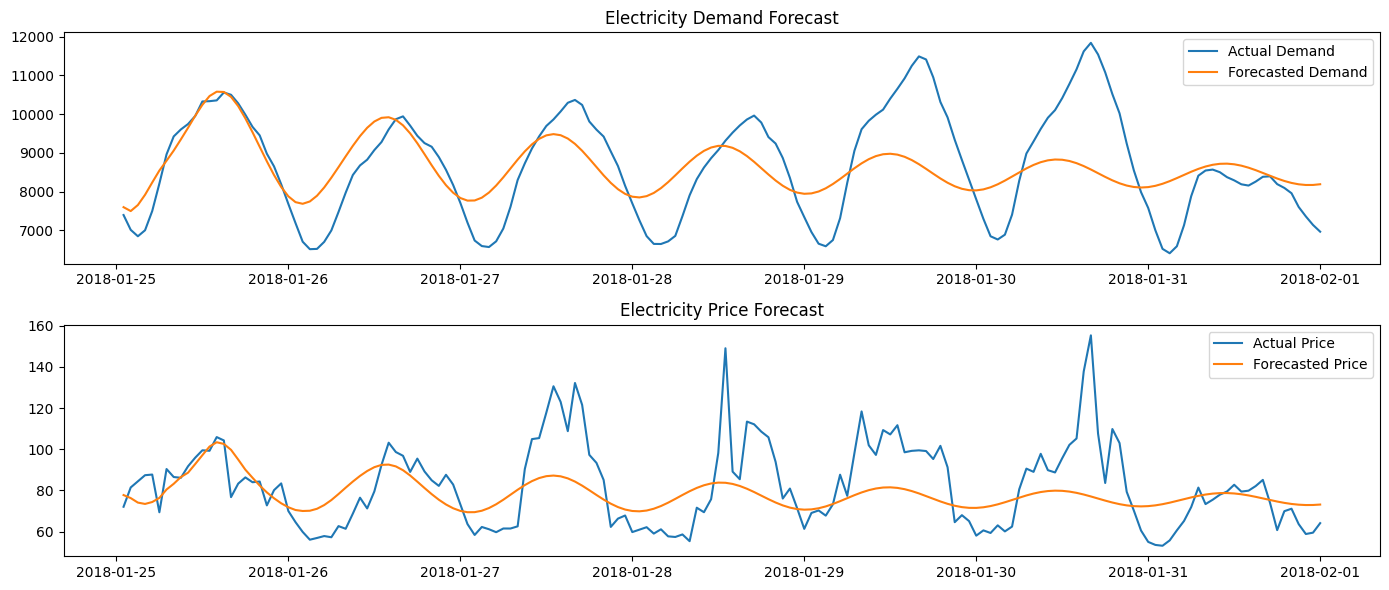

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error

# 1. Load and preprocess data
df = pd.read_csv('/content/PRICE_AND_DEMAND_201801_NSW1.csv')
df['SETTLEMENTDATE'] = pd.to_datetime(df['SETTLEMENTDATE'])
df.set_index('SETTLEMENTDATE', inplace=True)

# Select only the columns needed for forecasting
df = df[['TOTALDEMAND', 'RRP']]

# Resample to hourly data
df = df.resample('H').mean().dropna()

# 2. Train-test split
n_obs = 24 * 7  # Use last 7 days for testing
train, test = df[:-n_obs], df[-n_obs:]

# 3. Fit the VAR model
model = VAR(train)
results = model.fit(maxlags=15, ic='aic')

# 4. Forecast
lag_order = results.k_ar
forecast_input = train.values[-lag_order:]

forecast = results.forecast(y=forecast_input, steps=n_obs)
forecast_df = pd.DataFrame(forecast, index=test.index, columns=['TOTALDEMAND_forecast', 'RRP_forecast'])

# 5. Evaluation
rmse_demand = np.sqrt(mean_squared_error(test['TOTALDEMAND'], forecast_df['TOTALDEMAND_forecast']))
rmse_rrp = np.sqrt(mean_squared_error(test['RRP'], forecast_df['RRP_forecast']))
print(f'RMSE (Demand): {rmse_demand:.2f}')
print(f'RMSE (RRP): {rmse_rrp:.2f}')

# 6. Plot results
plt.figure(figsize=(14, 6))

plt.subplot(2, 1, 1)
plt.plot(test['TOTALDEMAND'], label='Actual Demand')
plt.plot(forecast_df['TOTALDEMAND_forecast'], label='Forecasted Demand')
plt.title('Electricity Demand Forecast')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(test['RRP'], label='Actual Price')
plt.plot(forecast_df['RRP_forecast'], label='Forecasted Price')
plt.title('Electricity Price Forecast')
plt.legend()

plt.tight_layout()
plt.show()
